# FCN

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torchmetrics

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


## Coco Data

In [3]:
def get_dataset(dir_path, name, image_set, transform):
    def sbd(*args, **kwargs):
        return torchvision.datasets.SBDataset(*args, mode="segmentation", **kwargs)

    paths = {
        "voc": (dir_path, torchvision.datasets.VOCSegmentation, 21),
        "voc_aug": (dir_path, sbd, 21),
        # "coco": (dir_path, get_coco, 21),
    }
    p, ds_fn, num_classes = paths[name]

    ds = ds_fn(p, image_set=image_set, transforms=transform)
    return ds, num_classes

In [5]:
import presets

transform = presets.SegmentationPresetTrain(base_size=520, crop_size=480)

In [6]:
dataset, num_classes = get_dataset('../data_voc', 'voc', "train", transform)

In [7]:
dataloader = DataLoader(
    dataset,
    batch_size=4,
    # sampler=train_sampler,
    # collate_fn=utils.collate_fn,
    drop_last=True,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


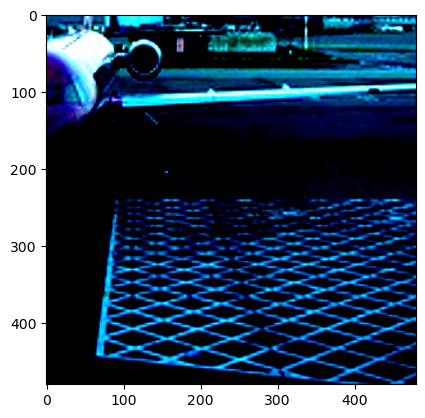

In [8]:
img, target = next(iter(dataloader))

plt.imshow(img[0].permute(1,2,0))

In [12]:
target[0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

[  0   1 255]


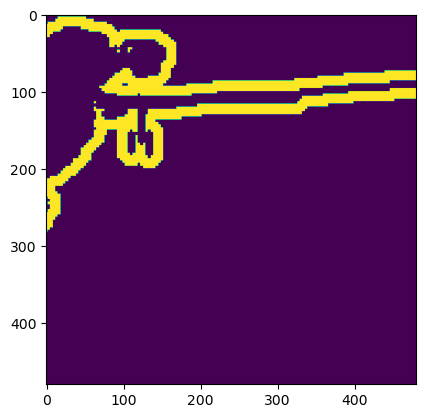

In [13]:
print(np.unique(target[0].numpy()))
plt.imshow(target[0])

In [ ]:
target[0].shape

## Dataset

In [69]:
data_dir = '../dataset/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
unlabel_dir = data_dir + 'unlabeled/'

In [70]:
class MaskDataset(Dataset):
    def __init__(self, root='../dataset/train/', transform=None):
        self.root = root
        self.transform = transform
        self.vid_list = sorted(os.listdir(root))
        self.img_list = ['image_' + str(i) + '.png' for i in range(22)]
    
    def __len__(self):
        return len(self.vid_list) * 22

    def __getitem__(self, idx):
        vid_idx = idx // 22
        img_idx = idx % 22
        # load image
        img_path = os.path.join(self.root, self.vid_list[vid_idx], self.img_list[img_idx])
        img = Image.open(img_path).convert("RGB")
        # load mask
        mask_path = os.path.join(self.root, self.vid_list[vid_idx], 'mask.npy')
        target = np.load(mask_path)[img_idx]
        # transforms
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [71]:
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset_train = MaskDataset(transform=transform)

In [72]:
len(dataset_train)

22000

In [28]:
dataloader = DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
)

img, target = next(iter(dataloader))
print(img.shape, target.shape)

torch.Size([128, 3, 160, 240]) torch.Size([128, 160, 240])


## Train

In [29]:
lr = 1e-2
batch_size = 8

In [30]:
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [31]:
model = models.segmentation.fcn_resnet50(
    weights=None,
    weights_backbone=models.ResNet50_Weights.IMAGENET1K_V2, 
    num_classes=49,
    aux_loss=True
).to(device)


In [32]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target)

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]

In [33]:
params_to_optimize = [
    {"params": [p for p in model.backbone.parameters() if p.requires_grad]},
    {"params": [p for p in model.classifier.parameters() if p.requires_grad]},
]

params = [p for p in model.aux_classifier.parameters() if p.requires_grad]
params_to_optimize.append({"params": params, "lr": lr * 10})

optimizer = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)

In [ ]:
for epoch in range(1):
    print(epoch)
    for imgs, targets in dataloader:
        imgs, targets = imgs.to(device), targets.to(device)
        
        output = model(imgs)
        loss = criterion(output, targets.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(loss.item())


## Evaluation

In [103]:
imgs, targets = next(iter(dataloader))
# imgs, targets = img.to(device), targets.to(device)

outputs = model(imgs.to(device))

In [109]:
imgs.size(0)

8

In [104]:
output = outputs['out']
output.shape

torch.Size([8, 49, 160, 240])

In [105]:
output = output.cpu().detach().numpy()
output_predictions = output.argmax(1)
output_predictions.shape

(8, 160, 240)

In [106]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49, average='micro')

print(jaccard(torch.Tensor(output_predictions), targets).item())

s = 0.0
for i in range(8):
    j = jaccard(torch.Tensor(output_predictions[i]), targets[i]).item()
    s += j

s / 8

0.0005406567361205816


0.0005414167294475192

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


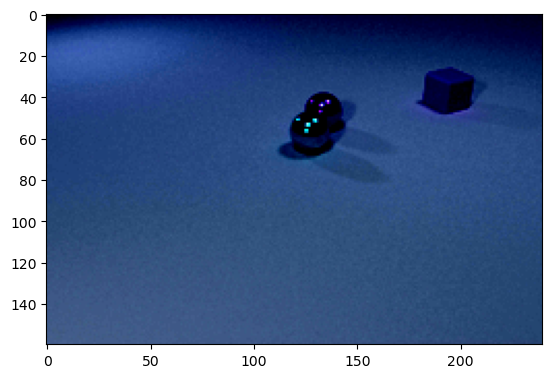

In [38]:
plt.imshow(imgs[0].permute(1,2,0))

In [ ]:
plt.imshow(output_predictions[0])
output_predictions[0]

In [ ]:
plt.imshow(targets[0])

## Inference

In [113]:
model_path = './output/fcn_resnet50_jaccard_0.2346/fcn_resnet50_best.pth'

model = models.segmentation.fcn_resnet50(num_classes=49, aux_loss=True)

model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [164]:
imgs, targets = next(iter(dataloader))
imgs = imgs.to(device)

In [165]:
outputs = model(imgs)
outs = outputs['out'].cpu().detach().numpy()
out_pred = outs.argmax(1)
out_pred.shape

(8, 160, 240)

48

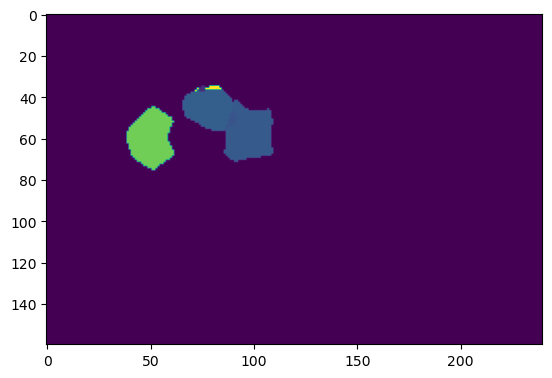

In [166]:
plt.imshow(out_pred[0])
out_pred.max()

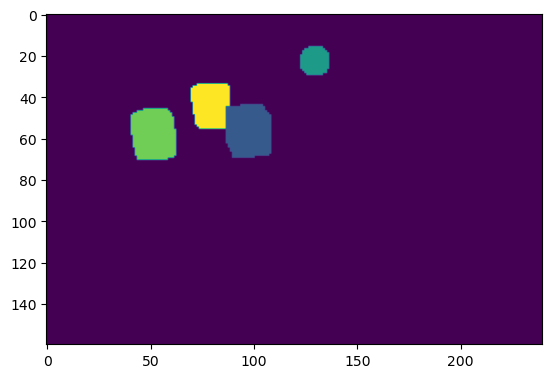

In [167]:
plt.imshow(targets[0].cpu())

In [119]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49)
jaccard(targets[0], torch.Tensor(out_pred[0])).item()

0.0711650624871254

In [120]:
3 / 49

0.061224489795918366

In [52]:
mask_path = os.path.join(train_dir, 'video_0', 'mask.npy')
mask = np.load(mask_path)[0]

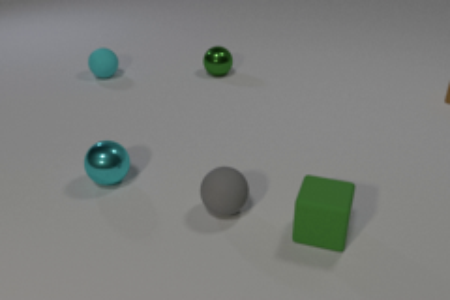

In [64]:
from torchvision.transforms import functional as F

size = 300

img = F.resize(img, size)

img

In [68]:
target = torch.Tensor(mask).unsqueeze(0)
print(target.shape)

target = F.resize(target, 250, interpolation=transforms.InterpolationMode.NEAREST)
target.shape

torch.Size([1, 160, 240])


torch.Size([1, 250, 375])

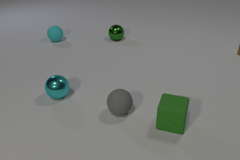

In [59]:
img_path = os.path.join(train_dir, 'video_0', 'image_0.png')
img = Image.open(img_path).convert('RGB')
img

In [112]:
from torchinfo import summary


model = models.vit_b_16()

summary(model, input_size=(3, 224, 224), batch_dim=0)

/Users/louis/anaconda3/envs/dl/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/louis/anaconda3/envs/dl/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 1000]                 768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             